In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
from __future__ import annotations

# # debugging
# from jax.tree_util import tree_map
# import jax.tree_util

import os
import matplotlib.pyplot as plt
from typing import Tuple, Optional

plt.style.use('default')
from pathlib import Path
import sys
from dataclasses import dataclass, replace
sys.path.append(os.path.abspath('..'))
import time

import jax
# jax.config.update("jax_default_matmul_precision", "tensorfloat32")
import jax.numpy as jnp
jnp.set_printoptions(precision=6, suppress=True)
import numpy as np

from floris import FlorisModel, TimeSeries

# from diffwake.diffwake_jax.model import load_input, create_state
# from diffwake.diffwake_jax import model
# from diffwake.diffwake_jax.layout_runner import make_layout_runner
# from diffwake.diffwake_jax.util import average_velocity_jax
# from diffwake.diffwake_jax.turbine.operation_models import power as power_fn
# from diffwake.diffwake_jax.simulator import simulate


# Wake model-agnostic edits to DiffWake
from diffwake.diffwake_jax.layout_runner import make_layout_runner
from diffwake.diffwake_jax.model import load_input, create_state, alter_yaw_angles
from diffwake.diffwake_jax.util import average_velocity_jax, State, Result, set_cfg, Config, set_precision
from diffwake.diffwake_jax.turbine.operation_models import power as power_fn
from diffwake.diffwake_jax.simulator import simulate_simp, simulate
from wrapper import DiffWakeParams, DiffWakeSimulation, DiffWakeConfig


def absolute_percentage_difference(a, b):
    return jnp.abs((a - b) / b) * 100

# debugging helper
def check_types(x):
    print(f"Type: {type(x)}, value shape: {getattr(x, 'shape', 'N/A')}")
    return x

def set_dtype(arg: Optional = None):
    if arg is None:
        return jnp.float64 if jax.config.x64_enabled else jnp.float32
    else:
        return arg

DTYPE = set_precision("float32")

In [9]:
lo = 'horn'
# data_dir = Path(f"data/{lo}")
# cc_farm = f"cc_{lo}sRev.yaml"
# gch_farm = f"gauss_{lo}sRev.yaml"
# gen_file = "vestas_v802MW.yaml"

data_dir = Path(f"data/simple")
cc_farm = f"cc_simple.yaml"
gch_farm = f"gch_simple.yaml"
gen_file = "vestas_v802MW.yaml"


# Cartesian coordinates in metres
override_layout = False
layout_x = jnp.array([0.0, 500.0, 1000.0], dtype=DTYPE)
layout_y = jnp.array([0.0, 500.0, 1000.0], dtype=DTYPE)

# Inflow speed in m/s
wind_speed = jnp.array([13.5], dtype=DTYPE)
wind_dir = jnp.array([jnp.deg2rad(270.0)], dtype=DTYPE)
ti = jnp.array([0.06], dtype=DTYPE)

# Load configurations for each wake model
cc_config = DiffWakeConfig(data_dir, cc_farm, gen_file, dtype=DTYPE)
gch_config = DiffWakeConfig(data_dir, gch_farm, gen_file, dtype=DTYPE)


if override_layout == False:
    cc_params = DiffWakeParams(wind_speed=wind_speed,
                               wind_directions=wind_dir,
                               turbulence_intensities=ti)
    gch_params = DiffWakeParams(wind_speed=wind_speed,
                                wind_directions=wind_dir,
                                turbulence_intensities=ti)

else:
    cc_params = DiffWakeParams(layout_x=layout_x,
                               layout_y=layout_y,
                               wind_speed=wind_speed,
                               wind_directions=wind_dir,
                               turbulence_intensities=ti)
    gch_params = DiffWakeParams(layout_x=layout_x,
                               layout_y=layout_y,
                               wind_speed=wind_speed,
                               wind_directions=wind_dir,
                               turbulence_intensities=ti)


# Prepare simulations
cc_sim = DiffWakeSimulation(cc_config, cc_params)
cc_state, cc_result, cc_runtime = cc_sim.run()
cc_farm_power = cc_sim.get_farm_power()

gch_sim = DiffWakeSimulation(gch_config, gch_params)
gch_state, gch_result, gch_runtime = gch_sim.run()
gch_farm_power = gch_sim.get_farm_power()


v_wake after zeros:  (1, 3, 3, 3)
w_wake after zeros:  (1, 3, 3, 3)
v_wake after transverse velocities:  (1, 3, 3, 3)
w_wake after transverse velocities:  (1, 3, 3, 3)
u_i shape: (1, 1, 3, 3)
v_i shape: (1, 1, 3, 3)
ti_i shape: (1, 1, 3, 3)
w_i shape: (1, 1, 3, 3)
v_wake_i shape: (1, 1, 3, 3)
w_wake_i shape: (1, 1, 3, 3)
I_mixing shape: (1, 1, 1, 1)
ti_i shape: (1, 1, 3, 3)
Updated shape: (1, 1, 3, 3)
TI shape: (1, 3, 3, 3)
v_wake after zeros:  (1, 3, 3, 3)
w_wake after zeros:  (1, 3, 3, 3)
v_wake after transverse velocities:  (1, 3, 3, 3)
w_wake after transverse velocities:  (1, 3, 3, 3)
u_i shape: (1, 1, 3, 3)
v_i shape: (1, 1, 3, 3)
ti_i shape: (1, 1, 3, 3)
w_i shape: (1, 1, 3, 3)
v_wake_i shape: (1, 1, 3, 3)
w_wake_i shape: (1, 1, 3, 3)
I_mixing shape: (1, 1, 1, 1)
ti_i shape: (1, 1, 3, 3)
Updated shape: (1, 1, 3, 3)
TI shape: (1, 3, 3, 3)
v_wake after zeros:  (1, 3, 3, 3)
w_wake after zeros:  (1, 3, 3, 3)
v_wake after transverse velocities:  (1, 3, 3, 3)
w_wake after transverse ve

### FLORIS simulation & DiffWake comparisons

In [4]:
# Horns Rev 1 simulation
fmodel = FlorisModel(r"..\floris\examples\inputs\cc_vesta.yaml")

fmodel_gch = FlorisModel(r"..\floris\examples\inputs\gauss_vesta.yaml")

time_series = TimeSeries(
    wind_directions=np.array([270.0]),
    wind_speeds=np.array([13.5]),
    turbulence_intensities=0.06,
)

fmodel.set(wind_data=time_series)
cc_start_time = time.time()
fmodel.run()
cc_end_time = time.time()


fmodel_gch.set(wind_data=time_series)
gch_start_time = time.time()
fmodel_gch.run()
gch_end_time = time.time()

# FLORIS does not convert to MW automatically
gch_farm_power_floris = fmodel_gch.get_farm_power() / 1e6
gch_turbine_powers_floris = fmodel_gch.get_turbine_powers()
cc_farm_power_floris = fmodel.get_farm_power() / 1e6
cc_turbine_powers_floris = fmodel.get_turbine_powers()


# Set printing precision
print("---------- DiffWake JAX Results ----------")
# print(f"Turbine powers with Gauss-Curl Hybrid (W): {gch_powers}")
print(f"Total farm power with GCH (MW): {gch_farm_power:.3f}")
# print(f"\nTurbine powers with Cumulative-Curl (W): {cc_powers}")
print(f"Total farm power with CC (MW): {cc_farm_power:.3f}")

print("\n---------- FLORIS Results ----------")
# print(f"Turbine powers with Gauss-Curl Hybrid (W): {gch_turbine_powers_floris}")
print(f"Total farm power with GCH (MW): {gch_farm_power_floris[0]:.3f}")
# print(f"\nTurbine powers with Cumulative-Curl (W): {cc_turbine_powers_floris}")
print(f"Total farm power with CC (MW): {cc_farm_power_floris[0]:.3f}")

print("\n---------- Differences ----------")
print(f"Absolute farm power difference (GCH) = {absolute_percentage_difference(gch_farm_power_floris, gch_farm_power)[0]:.6f}%")
print(f"Absolute farm power difference (CC) = {absolute_percentage_difference(cc_farm_power_floris, cc_farm_power)[0]:.6f}%")


---------- DiffWake JAX Results ----------
Total farm power with GCH (MW): 142.646
Total farm power with CC (MW): 97.611

---------- FLORIS Results ----------
Total farm power with GCH (MW): 142.661
Total farm power with CC (MW): 97.540

---------- Differences ----------
Absolute farm power difference (GCH) = 0.010066%
Absolute farm power difference (CC) = 0.072627%


In [13]:
print("------------ FLORIS runtimes ------------")
print(f"Cumulative-Curl: {cc_end_time - cc_start_time:.4f}s")
print(f"Gauss-Curl Hybrid: {gch_end_time - gch_start_time:.4f}s")

print("\n------------ DiffWake runtimes ------------")
print(f"Cumulative-Curl: {cc_runtime:.4f}s")
print(f"Gauss-Curl Hybrid: {gch_runtime:.4f}s")

------------ FLORIS runtimes ------------
Cumulative-Curl: 0.2000s
Gauss-Curl Hybrid: 0.1136s

------------ DiffWake runtimes ------------
Cumulative-Curl: 1.6728s
Gauss-Curl Hybrid: 1.2533s


## jax.lax

Because the problem is relatively simple, we will now compare multi-direction and speed simulations to see if JAX provides an improvement.

DiffWake having a longer runtime is expected due to the relatively simple nature of the problem; the overheads are non-trivial.

There are options like lax.scan and lax.fori_loop but they serve different purposes.

Here we test simple simulations using lax.fori_loop since the history isn't stored.

If we wanted to store history and use reverse-mode automatic differentiation, we would most definitely switch to lax.scan which is not implemented in DiffWake as of now.


In [14]:
# Run using lax_fori
_, _, cc_lax_runtime = cc_sim.run(scan=True)
_, _, gch_lax_runtime = gch_sim.run(scan=True)

In [15]:
print("------------ FLORIS runtimes ------------")
print(f"Cumulative-Curl: {cc_end_time - cc_start_time:.4f}s")
print(f"Gauss-Curl Hybrid: {gch_end_time - gch_start_time:.4f}s")


print("\n------------ DiffWake runtimes (simple for-loop) ------------")
print(f"Cumulative-Curl: {cc_runtime:.4f}s")
print(f"Gauss-Curl Hybrid: {gch_runtime:.4f}s")

print("\n------------ DiffWake runtimes (jax.lax.fori_loop) ------------")
print(f"Cumulative-Curl: {cc_lax_runtime:.4f}s")
print(f"Gauss-Curl Hybrid: {gch_lax_runtime:.4f}s")

# Power results verification using lax fori
cc_lax_farm_power = cc_sim.get_farm_power()
gch_lax_farm_power = gch_sim.get_farm_power()

print("\n------------ DiffWake powers (jax.lax.fori_loop) ------------")
print(f"Total farm power (MW): {cc_lax_farm_power:.3f}")
print(f"Total farm power (MW): {gch_lax_farm_power:.3f}\n")

print("---------- DiffWake JAX (no lax) Results ----------")
# print(f"\nTurbine powers with Cumulative-Curl (W): {cc_powers}")
print(f"Total farm power (MW): {cc_farm_power:.3f}")
# print(f"Turbine powers with Gauss-Curl Hybrid (W): {gch_powers}")
print(f"Total farm power (MW): {gch_farm_power:.3f}")


print("\n---------- FLORIS Results ----------")
# print(f"Turbine powers with Gauss-Curl Hybrid (W): {gch_turbine_powers_floris}")
print(f"Total farm power (MW): {gch_farm_power_floris[0]:.3f}")
# print(f"\nTurbine powers with Cumulative-Curl (W): {cc_turbine_powers_floris}")
print(f"Total farm power (MW): {cc_farm_power_floris[0]:.3f}")


------------ FLORIS runtimes ------------
Cumulative-Curl: 0.2000s
Gauss-Curl Hybrid: 0.1136s

------------ DiffWake runtimes (simple for-loop) ------------
Cumulative-Curl: 1.6728s
Gauss-Curl Hybrid: 1.2533s

------------ DiffWake runtimes (jax.lax.fori_loop) ------------
Cumulative-Curl: 0.6571s
Gauss-Curl Hybrid: 0.5247s

------------ DiffWake powers (jax.lax.fori_loop) ------------
Total farm power (MW): 98.106
Total farm power (MW): 142.964

---------- DiffWake JAX (no lax) Results ----------
Total farm power (MW): 98.106
Total farm power (MW): 142.964

---------- FLORIS Results ----------
Total farm power (MW): 142.661
Total farm power (MW): 97.540


These results are a good start. Although it is just a simple 80-turbine simulation of the Horns Rev 1 farm, we can see how running lax.fori_loop (similar to a C-style loop) can increase the runtime performance significantly.

We can increase performance further by using vmap (vectorised mapping) to process simulations in batches.

### FLORIS vs DiffWake (using vectorised mapping)
Let's run through GCH and CC simulations using FLORIS and DiffWake to see the performance improvements.
The JAX-based implementations of GCH and CC should both yield linear runtimes whereas the FLORIS implementation of CC should lead to a runtime that varies quadratically with the number of turbines N (due to the nested loop). The FLORIS GCH implementation should be linear, since it only loops through the turbines once.
### 360 unique wind directions and 16  unique wind speeds using FLORIS and DiffWake
#### JAX

#### Vectorised mapping (vmap) without JIT

In [20]:
farm_powers = []
turbine_powers = []

# Conditions we want to test
wind_speeds = jnp.arange(2.0, 18.0, 1.0)
wind_directions = jnp.arange(0.0, 360.0, 1.0)
ti_table = 0.06

# Permutation grid of wind conditions
ws_grid, wd_grid = jnp.meshgrid(wind_speeds, wind_directions, indexing="ij")

ws_flat = ws_grid.flatten()
wd_flat = wd_grid.flatten()
ti_flat = jnp.full_like(ws_flat, ti_table)

gch_profile_cfg = load_input(farm_path=data_dir / gch_farm,
                     generator_path=data_dir / gen_file).set(
    wind_speeds=jnp.array([9.0]),
    wind_directions=jnp.deg2rad(jnp.array([270.0])),
    turbulence_intensities=jnp.array([0.06])
)

cc_profile_cfg = load_input(farm_path=data_dir / cc_farm,
                            generator_path=data_dir / gen_file).set(
    wind_speeds=jnp.array([9.0]),
    wind_directions=jnp.deg2rad(jnp.array([270.0])),
    turbulence_intensities=jnp.array([0.06])
)

gch_base_state = create_state(gch_profile_cfg)
cc_base_state = create_state(cc_profile_cfg)

# Initialise the base configuration outside of the

# To fix this JIT, config has to be a static type since the base doesn't change, but the flow-field does change.
# Wrapper function to wrap in vmap
def run_single_case(ws: float,
                    wd: float,
                    ti: float,
                    base_state: State):

    ws = jnp.array([ws])
    wd = jnp.array([wd])
    ti = jnp.array([ti])

    new_state = base_state.replace(
        flow=base_state.flow.replace(
            wind_speeds=ws,
            wind_directions=wd,
            turbulence_intensities=ti
        )
    )

    return simulate(new_state)

cc_vmap = jax.vmap(run_single_case, in_axes=(0, 0, 0, None))
gch_vmap = jax.vmap(run_single_case, in_axes=(0, 0, 0, None))

# GCH vmap performance
start_time = time.time()
gch_vmap_results = gch_vmap(ws_flat, wd_flat, ti_flat, gch_base_state)
jax.tree_util.tree_map(lambda x: x.block_until_ready(), gch_vmap_results)
end_time = time.time()

gch_vmap_runtime = end_time - start_time
print(f"GCH (vmap only) runtime: {gch_vmap_runtime:.4f}s")

# CC vmap performance
start_time = time.time()
cc_vmap_results = cc_vmap(ws_flat, wd_flat, ti_flat, cc_base_state)
jax.tree_util.tree_map(lambda x: x.block_until_ready(), cc_vmap_results)
end_time = time.time()

cc_vmap_runtime = end_time - start_time
print(f"CC (vmap only) runtime: {cc_vmap_runtime:.4f}s")

E:\Aeronautics\FYP\.venv\Lib\site-packages\jax\_src\interpreters\mlir.py:1274: UserWarning: Some donated buffers were not usable: float32[1,80,3,3], float32[1,80,3,3], float32[1,80,3,3], float32[1,80,3,3].
See an explanation at https://docs.jax.dev/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


GCH (vmap only) runtime: 6.0964s


E:\Aeronautics\FYP\.venv\Lib\site-packages\jax\_src\interpreters\mlir.py:1274: UserWarning: Some donated buffers were not usable: float32[1,80,3,3], float32[1,80,3,3], float32[1,80,3,3], float32[1,80,3,3], float32[80,1,80,3,3], float32[1,80,1,1].
See an explanation at https://docs.jax.dev/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


CC (vmap only) runtime: 39.2173s


In [22]:
print(f"Number of simulations: {ws_flat.shape[0]}")
print(f"Average time per GCH simulation: {(gch_vmap_runtime/ws_flat.shape[0]):.8f}s")
print(f"Average time per CC simulation: {(cc_vmap_runtime/ws_flat.shape[0]):.8f}s")


Number of simulations: 5760
Average time per GCH simulation: 0.00105840s
Average time per CC simulation: 0.00680857s


## Numerical precision tests
Physical simulations require accuracy but there can be a big runtime tradeoff when switching between FP16, FP32 and FP64 precision.
Let's use 4 cases:
1. A row of 3 turbines at x = [0.0, 400.0, 800.0], unyawed
2. A row of 3 turbines at x = [0.0, 400.0, 800.0], yawed at [20.0, 10.0, 0.0]
3. Horns Rev 1, unyawed
4. Horns Rev 1, all yawed at 10 degrees except the most downstream row, which is left unyawed.

All cases have the same wind speed, wind direction and turbulence intensity.

In [4]:
wake_model = "gauss"
data_dir = Path("data/horn")
farm_cfg_path = data_dir / f"{wake_model}_hornsRev.yaml"
turbine_cfg_path = data_dir / "vestas_v802MW.yaml"


# Set FP64
from diffwake.diffwake_jax.util import set_precision
DTYPE = set_precision("fp64")
print(f"Current floating point precision: {DTYPE}")

# Base configuration (unyawed)
cfg = load_input(farm_cfg_path, turbine_cfg_path)
ws_test = 13.5
wd_test = 270.0
ti_val_test = 0.06
layout_x = jnp.array([0.0, 400.0, 800.0], dtype=DTYPE)
layout_y = jnp.array([0.0, 0.0, 0.0], dtype=DTYPE)
wind_speed = jnp.array([ws_test], dtype=DTYPE)
wind_dir = jnp.array([jnp.deg2rad(wd_test)], dtype=DTYPE) # Wind from West
ti = jnp.array([ti_val_test], dtype=DTYPE)

def run_configuration(base_config: Config,
                      ws: jnp.ndarray,
                      wd: jnp.ndarray,
                      ti_val: jnp.ndarray,
                      layout: Tuple[jnp.ndarray, jnp.ndarray] = (None, None),
                      yaw_angles: jnp.ndarray = None,
                      dtype = jnp.float64):
    if None in layout:
        test_config = base_config.set(
            wind_speeds=ws,
            wind_directions=wd,
            turbulence_intensities=ti_val,
        )
    else:
        test_config = base_config.set(
            layout_x=layout[0],
            layout_y=layout[1],
            wind_speeds=ws,
            wind_directions=wd,
            turbulence_intensities=ti_val,
        )

    test_state = create_state(test_config)
    test_state = jax.tree_util.tree_map(
        lambda x: x.astype(dtype) if hasattr(x, "dtype") and jnp.issubdtype(x.dtype, jnp.floating) else x, test_state
    )

    if yaw_angles is not None:
        test_state_yawed = alter_yaw_angles(yaw_angles, test_state)
        time_start = time.time()
        test_result = simulate(test_state_yawed)
        jax.tree_util.tree_map(lambda x: x.block_until_ready(), test_result)
        time_end = time.time()
        tp = power_fn(power_thrust_table=test_state_yawed.farm.power_thrust_table,
                                      velocities=test_result.u_sorted,
                                      air_density=test_state_yawed.flow.air_density,
                                      yaw_angles=test_state_yawed.farm.yaw_angles)

    else:
        time_start = time.time()
        test_result = simulate(test_state)
        jax.tree_util.tree_map(lambda x: x.block_until_ready(), test_result)
        time_end = time.time()
        tp = power_fn(power_thrust_table=test_state.farm.power_thrust_table,
                                      velocities=test_result.u_sorted,
                                      air_density=test_state.flow.air_density,
                                      yaw_angles=test_state.farm.yaw_angles)


    # Watts
    farm_power = jnp.sum(tp)

    return test_result, tp, farm_power, time_end - time_start

Current floating point precision: <class 'jax.numpy.float64'>


### Run FP64 tests for all 4 configurations

Let's get an average runtime for each configuration in the unyawed and yawed states. If we execute run_configuration for 4 different cases 50 times, we will be running 200 simulations.

In [5]:
# ENABLE X64 AND VERIFY DTYPE IS FP64

print(f"x64 enabled: {jax.config.x64_enabled}")

def run_all_cases(config, dtype=jnp.float64):
    # Cases 1 and 2
    case1 = run_configuration(config, wind_speed, wind_dir, ti, layout=(layout_x, layout_y), dtype=dtype)
    case2 = run_configuration(config, wind_speed, wind_dir, ti, layout=(layout_x, layout_y), yaw_angles=jnp.deg2rad(jnp.array([[20.0, 10.0, 0.0]])), dtype=dtype)

    # Cases 3 and 4
    hr1_yaw = jnp.deg2rad(jnp.array([jnp.concatenate([jnp.full(70, 10.0), jnp.zeros(10)])]))
    case3 = run_configuration(config, wind_speed, wind_dir, ti, dtype=dtype)
    case4 = run_configuration(config, wind_speed, wind_dir, ti, yaw_angles=hr1_yaw, dtype=dtype)

    return case1, case2, case3, case4



x64 enabled: True


In [6]:
# Get the average runtime for all cases over N_runs runs using FP64
N_runs = 50

# Tracking runtimes
rt_1 = []
rt_2 = []
rt_3 = []
rt_4 = []

for i in range(N_runs):
    c1_fp64, c2_fp64, c3_fp64, c4_fp64 = run_all_cases(config=cfg, dtype=jnp.float64)

    # Append all runtimes and get the average
    rt_1.append(c1_fp64[3])
    rt_2.append(c2_fp64[3])
    rt_3.append(c3_fp64[3])
    rt_4.append(c4_fp64[3])

In [7]:
print("----- Average runtime per case (FP64) -----")
print(f"Case 1: {np.mean(rt_1):.4f}s")
print(f"Case 2: {np.mean(rt_2):.4f}s")
print(f"Case 3: {np.mean(rt_3):.4f}s")
print(f"Case 4: {np.mean(rt_4):.4f}s")

----- Average runtime per case (FP64) -----
Case 1: 0.5475s
Case 2: 0.5692s
Case 3: 0.5467s
Case 4: 0.5814s


### Disable X64 and use FP32

In [8]:
# Disable X64 and use FP32
DTYPE = set_precision("fp32")

# Override DTYPEs
ws_test = 13.5
wd_test = 270.0
ti_val_test = 0.06
layout_x = jnp.array([0.0, 400.0, 800.0], dtype=DTYPE)
layout_y = jnp.array([0.0, 0.0, 0.0], dtype=DTYPE)
wind_speed = jnp.array([ws_test], dtype=DTYPE)
wind_dir = jnp.array([jnp.deg2rad(wd_test)], dtype=DTYPE) # Wind from West
ti = jnp.array([ti_val_test], dtype=DTYPE)

# Tracking runtimes
rt_1_fp32 = []
rt_2_fp32 = []
rt_3_fp32 = []
rt_4_fp32 = []

for i in range(N_runs):
    c1_fp32, c2_fp32, c3_fp32, c4_fp32 = run_all_cases(config=cfg, dtype=jnp.float32)

    # Append all runtimes and get the average
    rt_1_fp32.append(c1_fp32[3])
    rt_2_fp32.append(c2_fp32[3])
    rt_3_fp32.append(c3_fp32[3])
    rt_4_fp32.append(c4_fp32[3])

E:\Aeronautics\FYP\.venv\Lib\site-packages\jax\_src\numpy\reductions.py:138: UserWarning: Explicitly requested dtype int64 requested in convert_element_type is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  a = lax.convert_element_type(a, computation_dtype)
E:\Aeronautics\FYP\.venv\Lib\site-packages\jax\_src\numpy\reductions.py:159: UserWarning: Explicitly requested dtype int64 requested in convert_element_type is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax.convert_element_type(result, dtype or result_dtype)
E:\Aeronautics\FYP\.venv\Lib\site-packages\jax\_src\numpy\array_methods.py:125: UserWarning: Explicitl

### FP16 analysis

In [9]:
DTYPE = set_precision("bfloat16")

# Override DTYPEs
ws_test = 13.5
wd_test = 270.0
ti_val_test = 0.06
layout_x = jnp.array([0.0, 400.0, 800.0], dtype=DTYPE)
layout_y = jnp.array([0.0, 0.0, 0.0], dtype=DTYPE)
wind_speed = jnp.array([ws_test], dtype=DTYPE)
wind_dir = jnp.array([jnp.deg2rad(wd_test)], dtype=DTYPE) # Wind from West
ti = jnp.array([ti_val_test], dtype=DTYPE)

# Helper functions
def cast_leaves(leaf):
    if isinstance(leaf, (jnp.ndarray, np.ndarray)):
        if jnp.issubdtype(leaf.dtype, jnp.floating):
            return jnp.array(leaf, dtype=DTYPE)
    elif isinstance(leaf, (float, np.float32, np.float64)):
        return jnp.array(leaf, dtype=DTYPE)
    return leaf

# Enforce FP16
cfg_bfp16 = load_input(farm_cfg_path, turbine_cfg_path)
cfg_bfp16 = jax.tree_util.tree_map(cast_leaves, cfg_bfp16)

# Tracking runtimes
rt_1_bfp16 = []
rt_2_bfp16 = []
rt_3_bfp16 = []
rt_4_bfp16 = []

for i in range(N_runs):
    c1_bfp16, c2_bfp16, c3_bfp16, c4_bfp16 = run_all_cases(config=cfg_bfp16, dtype=DTYPE)

    # Append all runtimes and get the average
    rt_1_bfp16.append(c1_bfp16[3])
    rt_2_bfp16.append(c2_bfp16[3])
    rt_3_bfp16.append(c3_bfp16[3])
    rt_4_bfp16.append(c4_bfp16[3])

In [10]:
DTYPE = set_precision("float16")

# Override DTYPEs
ws_test = 13.5
wd_test = 270.0
ti_val_test = 0.06
layout_x = jnp.array([0.0, 400.0, 800.0], dtype=DTYPE)
layout_y = jnp.array([0.0, 0.0, 0.0], dtype=DTYPE)
wind_speed = jnp.array([ws_test], dtype=DTYPE)
wind_dir = jnp.array([jnp.deg2rad(wd_test)], dtype=DTYPE) # Wind from West
ti = jnp.array([ti_val_test], dtype=DTYPE)

# Helper functions
def cast_leaves(leaf):
    if isinstance(leaf, (jnp.ndarray, np.ndarray)):
        if jnp.issubdtype(leaf.dtype, jnp.floating):
            return jnp.array(leaf, dtype=DTYPE)
    elif isinstance(leaf, (float, np.float32, np.float64)):
        return jnp.array(leaf, dtype=DTYPE)
    return leaf

# Enforce FP16
cfg_fp16 = load_input(farm_cfg_path, turbine_cfg_path)
cfg_fp16 = jax.tree_util.tree_map(cast_leaves, cfg_fp16)

# Tracking runtimes
rt_1_fp16 = []
rt_2_fp16 = []
rt_3_fp16 = []
rt_4_fp16 = []

for i in range(N_runs):
    c1_fp16, c2_fp16, c3_fp16, c4_fp16 = run_all_cases(config=cfg_fp16, dtype=DTYPE)

    # Append all runtimes and get the average
    rt_1_fp16.append(c1_fp16[3])
    rt_2_fp16.append(c2_fp16[3])
    rt_3_fp16.append(c3_fp16[3])
    rt_4_fp16.append(c4_fp16[3])

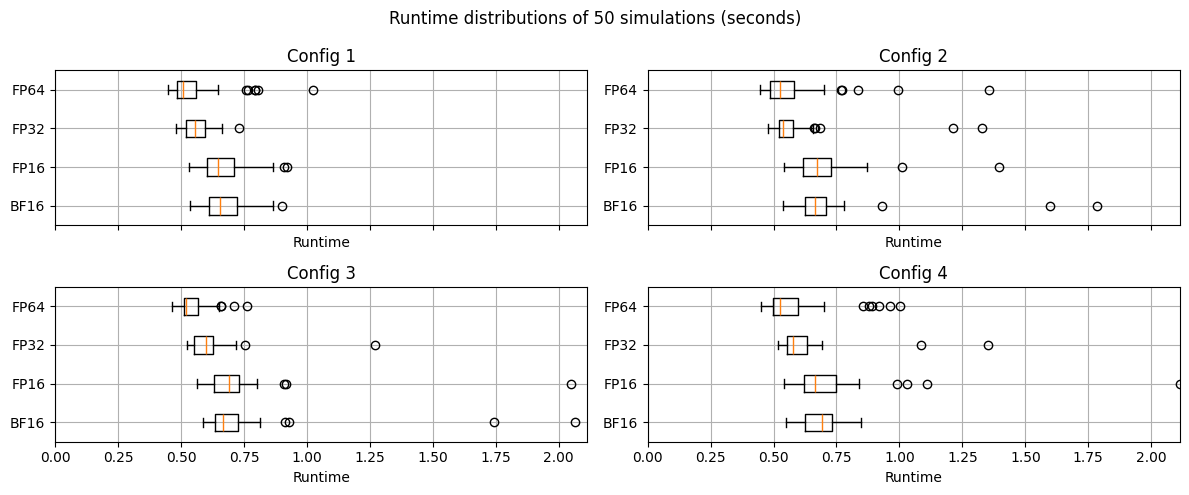

----- AVERAGE RUNTIME PER CASE (FP16) -----
Config 1: 0.6659s
Config 2: 0.6900s
Config 3: 0.7125s
Config 4: 0.7226s

----- AVERAGE RUNTIME PER CASE (FP32) -----
Case 1: 0.5624s
Case 2: 0.5796s
Case 3: 0.6112s
Case 4: 0.6154s


In [13]:
# Visualise the distribution of runtimes for all precisions
plt.style.use('default')
fig, ax = plt.subplots(2, 2, figsize=(12, 5), sharex=True)
max_runtime = np.max([rt_1_bfp16, rt_1_fp16, rt_1_fp32, rt_1,
                     rt_2_bfp16, rt_2_fp16, rt_2_fp32, rt_2,
                     rt_3_bfp16, rt_3_fp16, rt_3_fp32, rt_3,
                     rt_4_bfp16, rt_4_fp16, rt_4_fp32, rt_4])

ax[0][0].boxplot([rt_1_bfp16, rt_1_fp16, rt_1_fp32, rt_1], tick_labels=['BF16', 'FP16', 'FP32', 'FP64'],  orientation='horizontal')
ax[0][0].set_xlim(left=0.0, right=max_runtime)
ax[0][0].set_title("Config 1")
ax[0][0].set_xlabel("Runtime")
ax[0][0].grid()

ax[0][1].boxplot([rt_2_bfp16, rt_2_fp16, rt_2_fp32, rt_2], tick_labels=['BF16', 'FP16', 'FP32', 'FP64'],  orientation='horizontal')
ax[0][1].set_xlim(left=0.0, right=max_runtime)
ax[0][1].set_title("Config 2")
ax[0][1].set_xlabel("Runtime")
ax[0][1].grid()

ax[1][0].boxplot([rt_3_bfp16, rt_3_fp16, rt_3_fp32, rt_3], tick_labels=['BF16', 'FP16', 'FP32', 'FP64'],  orientation='horizontal')
ax[1][0].set_xlim(left=0.0, right=max_runtime)
ax[1][0].set_title("Config 3")
ax[1][0].set_xlabel("Runtime")
ax[1][0].grid()

ax[1][1].boxplot([rt_4_bfp16, rt_4_fp16, rt_4_fp32, rt_4], tick_labels=['BF16', 'FP16', 'FP32', 'FP64'],  orientation='horizontal')
ax[1][1].set_xlim(left=0.0, right=max_runtime)
ax[1][1].set_title("Config 4")
ax[1][1].set_xlabel("Runtime")
ax[1][1].grid()

fig.suptitle("Runtime distributions of 50 simulations (seconds)")
plt.tight_layout()
plt.show()

print("----- AVERAGE RUNTIME PER CASE (FP16) -----")
print(f"Config 1: {np.mean(rt_1_fp16):.4f}s")
print(f"Config 2: {np.mean(rt_2_fp16):.4f}s")
print(f"Config 3: {np.mean(rt_3_fp16):.4f}s")
print(f"Config 4: {np.mean(rt_4_fp16):.4f}s")

print("\n----- AVERAGE RUNTIME PER CASE (FP32) -----")
print(f"Case 1: {np.mean(rt_1_fp32):.4f}s")
print(f"Case 2: {np.mean(rt_2_fp32):.4f}s")
print(f"Case 3: {np.mean(rt_3_fp32):.4f}s")
print(f"Case 4: {np.mean(rt_4_fp32):.4f}s")